**Dependencies and setup** (this can take a minute or so...)

In [1]:
# !pip install swig

# !pip install rldurham  # latest release
# !pip install git+https://github.com/robert-lieck/rldurham.git@main  # latest main version (typically same as release)
# !pip install git+https://github.com/robert-lieck/rldurham.git@dev  # latest dev version

In [2]:
import gymnasium as gym
import rldurham as rld  # Reinforcement Learning Durham package with helper functions

**Basic environment**

In [3]:
env = gym.make('CartPole-v1', render_mode="human")
observation, info = env.reset(seed=42)

for episode in range(10):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

env.close()

**Reinforcement Learning Durham:** _rldurham_ Python package

{'recorder': {'idx': 10, 'length': 25, 'r_sum': 25.0, 'r_mean': 1.0, 'r_std': 0.0, 'length_': 34.0, 'r_sum_': 204.0, 'r_mean_': 34.0, 'r_std_': 17.281975195754296}}
{'recorder': {'idx': [0, 2, 4, 6, 8], 'length': [29, 69, 39, 14, 28], 'r_sum': [29.0, 69.0, 39.0, 14.0, 28.0], 'r_mean': [1.0, 1.0, 1.0, 1.0, 1.0], 'r_std': [0.0, 0.0, 0.0, 0.0, 0.0], 'length_': [29.0, 49.0, 45.666666666666664, 37.75, 35.8], 'r_sum_': [29.0, 98.0, 137.0, 151.0, 179.0], 'r_mean_': [29.0, 49.0, 45.666666666666664, 37.75, 35.8], 'r_std_': [0.0, 20.0, 16.996731711975958, 20.116846174288852, 18.410866356584094]}}


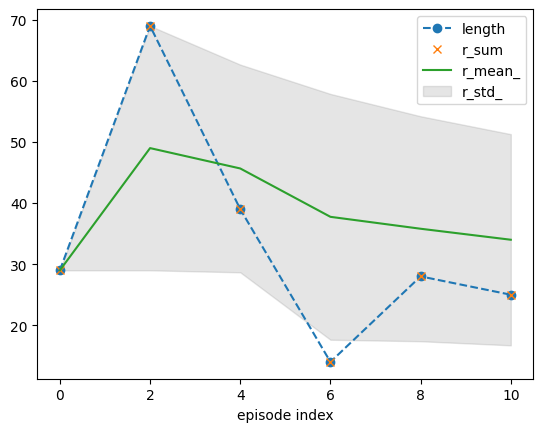

In [4]:
env = rld.make('CartPole-v1', render_mode="rgb_array")  # drop-in for gym.make
env = rld.Recorder(                                     # record statistics (returned in info) and videos
    env, 
    smoothing=10,                      # rolling averages
    video=True,                        # record videos
    video_folder="videos",             # folder for videos
    video_prefix="xxxx00-agent-video", # prefix for videos
    logs=True,                         # keep logs
)
seed, observation, info = rld.seed_everything(42, env)  # seed everything (python, numpy, pytorch, env)
tracker = rld.InfoTracker()                             # track statistics, e.g., for plotting

for episode in range(11):
    env.info = episode % 2 == 0   # track every other episode
    env.video = episode % 4 == 0  # set before reset! (is checked on reset)
    #######################################################################
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    #######################################################################
        if done:
            # track and plot statistics
            print(info)
            print(tracker.info)
            tracker.track(info)
            tracker.plot(r_mean_=True, r_std_=True, 
                         length=dict(linestyle='--', marker='o'),
                         r_sum=dict(linestyle='', marker='x'))

env.close()  # important (e.g. triggers last video save)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

**Different environments**

In [5]:
## render mode
rm="human"     # for visualising
# rm='rgb_array' # for recording videos
# rm=None        # no rendering

## select environment
env = rld.make('CartPole-v1', render_mode=rm)              # easy discrete
# env = rld.make('LunarLander-v2', render_mode=rm)           # discrete
# env = rld.make('Breakout-v0', render_mode=rm)              # discrete
# env = rld.make('Pong-ram-v0', render_mode=rm)              # discrete
# env = rld.make('Gravitar-ram-v0', render_mode=rm)          # hard discrete
#
# env = rld.make('Pendulum-v0', render_mode=rm)              # easy continuous
# env = rld.make('LunarLanderContinuous-v2', render_mode=rm) # continuous
# env = rld.make('BipedalWalker-v3', render_mode=rm)         # continuous
# env = rld.make('BipedalWalkerHardcore-v3', render_mode=rm) # hard continuous

## wrap for stats and video recording
# env = rld.Recorder(env, video=True)
# env.video = False  # deactivate

## get some info
discrete = hasattr(env.action_space, 'n')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The action space is: ' + ('discrete' if discrete else 'continuous'))
print('The maximum timesteps is: {}'.format(env.spec.max_episode_steps))

The environment has 4 observations and the agent can take 2 actions
The action space is: discrete
The maximum timesteps is: 500


In [6]:
for episode in range(1):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
env.close()

**Training an agent**

In [7]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('The device is: {}'.format(device))
if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The device is: cuda
It's recommended to train on the cpu for this


In [8]:
class Agent(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.discrete = hasattr(env.action_space, 'n')
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n if discrete else env.action_space.shape[0]

    def prob_action(self, obs):
        return np.ones(self.act_dim)/self.act_dim

    def sample_action(self, prob):
        if self.discrete:
            return np.random.choice(self.act_dim, p=prob)
        else:
            return np.random.uniform(-1.0, 1.0, size=self.act_dim)

    def train(self):
        return

    def put_data(self, item):
        return

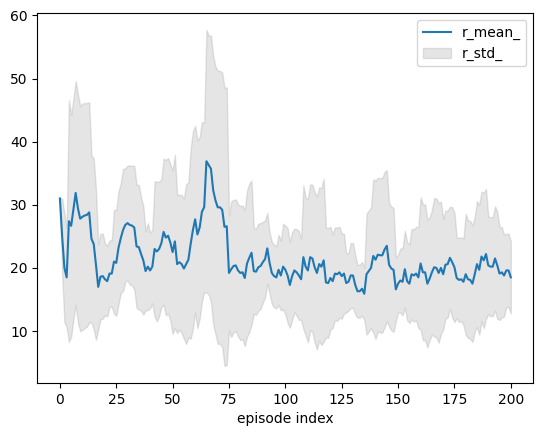

In [9]:
# init environment
env = rld.make('CartPole-v1')
env = rld.Recorder(env, smoothing=10)

# seed
rld.seed_everything(seed=42, env=env)

# init agent
agent = Agent(env)

# training procedure
tracker = rld.InfoTracker()
for episode in range(201):
    obs, info = env.reset()
    done = False

    # get episode
    while not done:
        # select action
        prob = agent.prob_action(obs)
        action = agent.sample_action(prob)

        # take action in environment
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.put_data((reward, prob[action] if discrete else None))
        obs = next_obs

    # track and plot
    tracker.track(info)
    if episode % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True)

    # update agent's policy
    agent.train()
env.close()

**REINFORCE agent example**
This code is based on: https://github.com/seungeunrho/minimalRL

Note: these implementations are good to study, although most are for discrete action spaces

In [10]:
# this is an implementation of REINFORCE (taught in lecture 8) - one of the simplest classical policy gradient methods
# this will only work for simple discrete control problems like cart pole or (slowly) lunar lander discrete
plot_interval = 50
video_every = 500
max_episodes = 5000

if not discrete:
    print("REINFORCE only works for discrete action spaces")
    raise AssertionError()

class Agent(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.data = []
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, act_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0002)

    def sample_action(self, prob):
        m = Categorical(prob)
        a = m.sample()
        return a.item()

    def prob_action(self, s):
        x = F.relu(self.fc1(torch.from_numpy(s).float()))
        return F.softmax(self.fc2(x), dim=0)

    def put_data(self, item):
        self.data.append(item)

    def train(self):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + 0.98 * R
            loss = -torch.log(prob) * R
            loss.backward()
        self.optimizer.step()
        self.data = []

**Custom environments (here: multi-armed bandits)**

In [11]:
# one armed bandits are slot machines where you can win or loose money
# some casinos tune them, so some machines are less successful (the probability distribution of winning)
# the machines also dish out varying rewards (the reward distribution)
# so basically each machine has some probability of dishing out £ reward (p_dist doesn't need to sum to 1) else it gives £0

class BanditEnv(gym.Env):

    def __init__(self, p_dist=[0.4,0.2,0.1,0.1,0.1,0.7], r_dist=[1,0.1,2,0.5,6,70]):

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = gym.spaces.Discrete(self.n_bandits)
        self.observation_space = gym.spaces.Discrete(1)

    def step(self, action):
        assert self.action_space.contains(action)

        reward = -25
        terminated = True
        truncated = False

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward += self.r_dist[action]
            else:
                reward += np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return np.zeros(1), reward, terminated, truncated, {}

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, seed = gym.utils.seeding.np_random(seed)
        return np.zeros(1), {}

    def render(self):
        pass

In [12]:
# initialise
discrete = True
env = BanditEnv()
obs_dim = 1
act_dim = len(env.p_dist)
env.spec = gym.envs.registration.EnvSpec('BanditEnv-v0', max_episode_steps=5)
max_episodes = 1000

for episode in range(10):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        print(action, reward)
        done = terminated or truncated

env.close()

0 -25
5 45
0 -24
0 -25
0 -25
5 45
3 -25
3 -25
0 -24
5 45
